In [1]:
from sympy import init_printing, symbols, sqrt, Add, eye, factor, simplify
init_printing()

In [2]:
from kinematics import V3D, FV, SpinorU, SpinorV
from sympy import sin, cos, I, pi, acos, atan
from sympy import Dummy, Abs, Interval, solveset, solve
from sympy.physics.matrices import mgamma
from sympy.physics.quantum.dagger import Dagger

## W decay into leptons

### kinematics

In [3]:
mW = symbols('m_W', positive=True)
E = symbols(r'E', positive=True)
th = V3D.th
phi = V3D.phi

In [4]:
px, py, pz = E*sin(th), 0, E*cos(th)
p3 = V3D(px, py, pz)
p4 = V3D(-px, py, -pz)


In [5]:
p3.polarform(phi=0).simplify(), p4.polarform(phi=pi, th=pi - th).simplify()


In [6]:
r = abs(p3).simplify()
r

In [7]:
atan(p3.py/p3.px)

In [8]:
th_domain = Interval(0, pi)
th_domain.as_relational(th)

In [9]:
th_domain.closure

In [10]:
th1 = acos(p3.pz/r).simplify()
th1

In [11]:
new_th_domain = solveset(acos(p3.pz/r) - acos(p3.pz/r).simplify(), th, domain=th_domain)
new_th_domain

In [12]:
new_th_domain.as_relational(th)

In [13]:
pmu1 = FV(mW, 0, 0, 0)
pmu3 = FV(E, p3.px, p3.py, p3.pz)
pmu4 = FV(E, p4.px, p4.py, p4.pz)

In [14]:
pmu3, pmu4

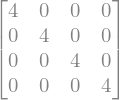

In [15]:
Add(*[mgamma(mu)*mgamma(mu, lower=True) for mu in range(4)])

### Massive vector polarizations along the z axis

In [16]:
eps_minus = FV(0, 1/sqrt(2), -I/sqrt(2), 0)
eps_L = FV(0, 0, 0, 1) # W boson at rest
eps_plus = FV(0, -1/sqrt(2), -I/sqrt(2), 0)

In [17]:
def polarization(type):
    if type == 1:
        out = eps_plus
    elif type == -1:
        out = eps_minus
    elif type == 0:
        out = eps_L
    else:
        raise ValueError("type must be 1, -1 or 0")
    return out

In [18]:
ml, mnu = symbols(r'm_\ell, m_\nu', positive=True)
u3 = lambda s3:SpinorU(pmu3, ml, s3)
v4 = lambda s4:SpinorV(pmu4, mnu, s4)
I4x4 = eye(4)

In [19]:

positive_l_plus = Dummy(positive=True)
positive_l_minus = Dummy(positive=True)

positive_nu_plus = Dummy(positive=True)
positive_nu_minus = Dummy(positive=True)

In [20]:
pmu3

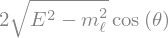

In [21]:
(u3(1).adj()*mgamma(3)*u3(1).matrixform())[0].subs(
        {
            E + ml:positive_l_plus,
            E - ml: positive_l_minus
        }
        ).subs(
            {
                positive_l_plus: E + ml,
                positive_l_minus: E - ml
            }
            ).simplify().subs(acos(cos(th)), th)

In [22]:
helicities = [1, -1]

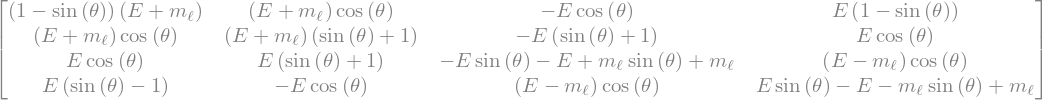

In [23]:
Add(*[(u3(s3).matrixform()*u3(s4).adj()) for s3 in helicities for s4 in helicities]
    ).subs(
        {
            E + ml:positive_l_plus,
            E - ml: positive_l_minus
        }
        ).subs(
            {
                positive_l_plus: E + ml,
                positive_l_minus: E - ml
            }
            ).subs(acos(cos(th)), th).simplify().subs(
    sqrt(E**2 - ml**2), E
)

In [24]:
g = (
    (u3(1).matrixform()*u3(1).adj()).subs(acos(cos(th)), th) + 
    (u3(-1).matrixform()*u3(-1).adj()).subs(acos(cos(th)), th)
).subs(
        {
            E + ml:positive_l_plus,
            E - ml: positive_l_minus
        }
        ).subs(
            {
                positive_l_plus: E + ml,
                positive_l_minus: E - ml
            }
        )
simplify(g).subs(
    sqrt(E**2 - ml**2), E
) == pmu3.slash() + ml*I4x4

True

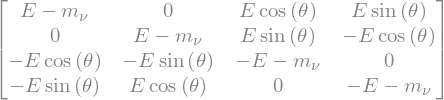

In [25]:
g = (
    (v4(1).matrixform()*v4(1).adj()).subs(acos(-cos(th)), th + pi) + 
    (v4(-1).matrixform()*v4(-1).adj()).subs(acos(-cos(th)), th + pi)
).subs(
        {
            E + mnu:positive_nu_plus,
            E - mnu: positive_nu_minus
        }
        ).subs(
            {
                positive_nu_plus: E + mnu,
                positive_nu_minus: E - mnu
            }
        )
simplify(g).subs(
    sqrt(E**2 - mnu**2), E
) #== pmu4.slash() - mnu*I4x4

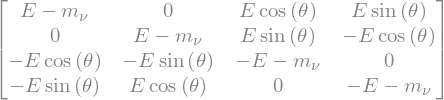

In [26]:
pmu4.slash() - mnu*I4x4

In [27]:
Jmu = lambda nu, s3, s4: (
    (u3(s3).adj()*mgamma(nu, lower=True)*v4(s4).matrixform())
    )[0].subs(acos(cos(th)), th).subs(acos(-cos(th)), th + pi).subs(
        {
            E + ml:positive_l_plus,
            E - ml: positive_l_minus
        }
        ).subs(
            {
                positive_l_plus: E + ml,
                positive_l_minus: E - ml
            }
        )
Jmu(0,1,1).simplify() #I4x4 - mgamma(5)

In [28]:
for mu in range(4):
    display(Jmu(mu,-1,1).subs(ml,0).subs(mnu,0).simplify())

In [29]:
(
    Jmu(1, 1, 1) + 
    Jmu(1, 1, -1) + 
    Jmu(1, -1, 1) + 
    Jmu(1, -1, -1)
    ).subs(acos(-cos(th)), th).simplify().subs(ml,0).subs(mnu,0).simplify()

In [30]:
gW = symbols('g_W', positive=True)
def M_polarization(pol_type, J):
    eps = polarization(pol_type).matrixform()
    factor = gW/sqrt(2)
    J0 = eps[0]*Jmu(0,-1,1)#.subs(ml,0).subs(mnu,0)
    J1 = eps[1]*Jmu(1,-1,1)#.subs(ml,0).subs(mnu,0)
    J2 = eps[2]*Jmu(2,-1,1)#.subs(ml,0).subs(mnu,0)
    J3 = eps[3]*Jmu(3,-1,1)#.subs(ml,0).subs(mnu,0)
    return factor*(J0 + J1 + J2 + J3)

In [31]:
high_energy_limit = {
                    ml:0, mnu:0
                }

In [32]:
M_plus = M_polarization(1,Jmu).subs(E, mW/2).simplify()
M_L = M_polarization(0,Jmu).subs(E, mW/2).simplify()
M_minus = M_polarization(-1,Jmu).subs(E, mW/2).simplify()

In [33]:
from sympy.simplify.fu import TR8

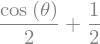

In [34]:
TR8(cos(th/2)**2)

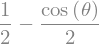

In [35]:
TR8(sin(th/2)**2)

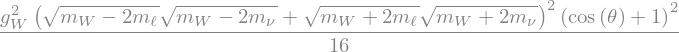

In [36]:
M_minus_square = TR8(M_minus).factor()**2
M_minus_square

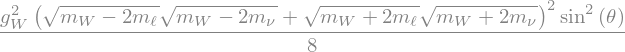

In [37]:
M_L_square = M_L.factor()**2
M_L_square


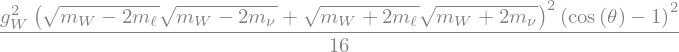

In [38]:
M_plus_square = TR8(M_plus).factor()**2
M_plus_square

In [39]:
from sympy import integrate

In [40]:
Ga_minus = integrate(
    M_minus_square.subs(E, mW/2)*sin(th), (th, 0, pi), (phi, 0, 2*pi))
Ga_L = integrate(
    M_L_square.subs(E, mW/2)*sin(th), (th, 0, pi), (phi, 0, 2*pi))
Ga_plus = integrate(
    M_plus_square.subs(E, mW/2)*sin(th), (th, 0, pi), (phi, 0, 2*pi))

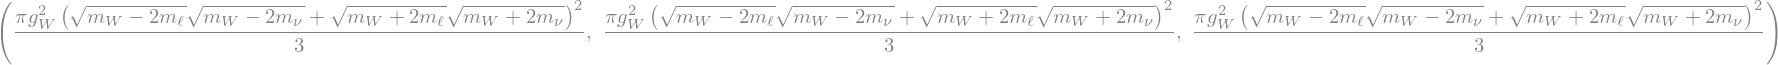

In [41]:
Ga_minus, Ga_L, Ga_plus

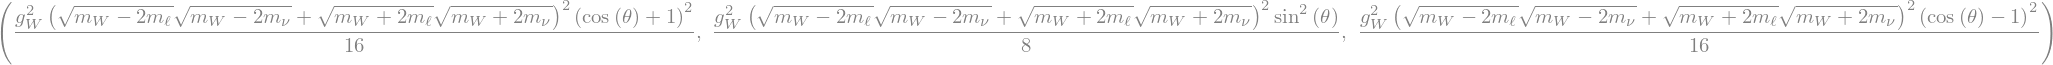

In [42]:
M_minus_square, M_L_square, M_plus_square

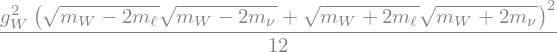

In [43]:
M_ave = ((M_L_square + M_plus_square + M_minus_square)/3).simplify()
M_ave

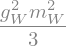

In [44]:
M_ave.subs(high_energy_limit)

In [45]:
mW_val = 80.377 # GeV
me_val = 0.000511 # GeV
mmu_val = 0.105 #GeV
mtau_val = 1.777 # GeV

In [46]:
M_ave.subs(mnu, 0).subs(
    {mW:mW_val, ml:me_val}
)

In [47]:
M_ave.subs(mnu, 0).subs(
    {mW:mW_val, ml:mmu_val}
)

In [48]:
M_ave.subs(mnu, 0).subs(
    {mW:mW_val, ml:mtau_val}
)

In [49]:
integrate(
    sin(th), (th, 0, pi), (phi, 0, 2*pi)
)

In [50]:
width_Wlnu = integrate(
    (M_ave*mW/2)/(32*pi**2*mW**2)*sin(th), (th, 0, pi), (phi, 0, 2*pi)
)

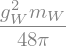

In [51]:
width_Wlnu.subs(high_energy_limit)